# Metaprediktor pre CNV

Importing all needed packages

In [185]:
import pandas as pd
import numpy as np
import glob
import gzip
import json
import keras
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest, f_classif
from keras.layers import Dense
from keras.models import Sequential


Reading all annotated cnvs

In [186]:
folder_path = ".././data/annotated_cnvs_json"  # Change this to your folder path

# Get a list of filenames matching the pattern "*.json.gz" in the folder
file_list = glob.glob(folder_path + "/*.json.gz")
annotated_list = []
for file_path in file_list:
    with gzip.open(file_path, 'rb') as f:
        # Read the content of the gzip file
        json_content = f.read()

        # Decode the gzip content
        json_str = json_content.decode('utf-8')

        # Parse the JSON content
        data = json.loads(json_str)
        genes = {}
        try:
            for item in data['genes']:
                
                for glob_attr, attributes in item.items():
                    for attr, value in attributes.items():
                        if attr !='raw' :
                            if(f'{value}'=='nan'):
                                genes[f"{glob_attr}_{attr}"] = "nan"
                            else:
                                genes[f"{glob_attr}_{attr}"] = value
            annotated_list.append({"chrom":data['chrom'],'start':data['start'],'end':data['end'],'cnv_type':data['cnv_type'],**genes} )
        except:
            pass
annotated_df = pd.json_normalize(annotated_list)
annotated_df['chrom'] =  annotated_df['chrom'].replace({'X': 23, 'Y': 24})
annotated_df['cnv_type'] = annotated_df['cnv_type'].replace({'gain': 1, 'loss': 0})


C:\Users\misha\AppData\Local\Temp\ipykernel_8068\3198203531.py:32: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  annotated_df['cnv_type'] = annotated_df['cnv_type'].replace({'gain': 1, 'loss': 0})


Reading table with clinSign

In [187]:
clinSign_df = pd.read_csv('clear_cnvcka.csv')

# Replacing Pathogenic -> 1 and Benign -> 0
clinSign_df['clinSign'] = clinSign_df['clinSign'].replace({'Pathogenic': 1, 'Benign': 0})

C:\Users\misha\AppData\Local\Temp\ipykernel_8068\519074208.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  clinSign_df['clinSign'] = clinSign_df['clinSign'].replace({'Pathogenic': 1, 'Benign': 0})


Converting tables to same type

In [188]:
def convert_to_int64(column):
    column = pd.to_numeric(column, errors='coerce')  # Convert to numeric, set invalid parsing as NaN
    column = column.fillna(-1).astype('int64')  # Handle NaN values appropriately, for example, replace with -1
    return column

# Select object columns and convert them to int64
for col in annotated_df.select_dtypes(include=['object']).columns:
    annotated_df[col] = convert_to_int64(annotated_df[col])
    
for col in clinSign_df.select_dtypes(include=['object']).columns:
    clinSign_df[col] = convert_to_int64(clinSign_df[col])

In [189]:
annotated_df = annotated_df.fillna(annotated_df.mean())
clinSign_df = clinSign_df.fillna(annotated_df.mean())

Table merging

In [190]:
# Perform a inner join based on "chrom", "start", "end"
merged_df = pd.merge(annotated_df, clinSign_df, on=["chrom", "start", "end"], how="inner")

In [191]:
merged_df.head()

,chrom,start,end,cnv_type,Pathway(ConsensusPathDB)_imputed_unscaled,Pathway(ConsensusPathDB)_imputed_scaled,Pathway(ConsensusPathDB)_unimputed_unscaled,Function_description_imputed_unscaled,Function_description_imputed_scaled,Function_description_unimputed_unscaled,...,Essential_gene_gene-trap_N_imputed_unscaled,Essential_gene_gene-trap_N_imputed_scaled,Essential_gene_gene-trap_N_unimputed_unscaled,Gene_indispensability_pred_E_imputed_unscaled,Gene_indispensability_pred_E_imputed_scaled,Gene_indispensability_pred_E_unimputed_unscaled,Gene_indispensability_pred_N_imputed_unscaled,Gene_indispensability_pred_N_imputed_scaled,Gene_indispensability_pred_N_unimputed_unscaled,clinSign
0,10,100194214,132432797,1,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1
1,10,100600491,133622588,1,0.0,0.0,0.0,1.0,1.0,1.0,...,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1
2,10,100677716,100764519,0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1
3,10,101120346,101831908,1,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1
4,10,101177304,101719109,1,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1


Finding the attributes that have the greatest impact on **clinSign**

In [192]:
x = merged_df.drop('clinSign', axis=1)
y = merged_df['clinSign']
input_len = 10
# Select top 10 features
selector = SelectKBest(f_classif, k=input_len)
X_new = selector.fit_transform(x, y)

# Get the selected feature names
selected_features = x.columns[selector.get_support()]
print(selected_features)

Index(['P(HI)_unimputed_unscaled', 'GHIS_unimputed_unscaled',
       'LoF-FDR_ExAC_unimputed_unscaled',
       'ExAC_nonTCGA_pLI_unimputed_unscaled',
       'ExAC_nonTCGA_pRec_unimputed_unscaled',
       'ExAC_nonTCGA_pNull_unimputed_unscaled',
       'gnomAD_pLI_unimputed_unscaled', 'gnomAD_pRec_unimputed_unscaled',
       'gnomAD_pNull_unimputed_unscaled',
       'Gene_indispensability_score_unimputed_unscaled'],
      dtype='object')


In [193]:
#Final dataframe with needed columns
final_df = merged_df.loc[:, [*selected_features,"clinSign"]]

In [194]:
final_df.head()

,P(HI)_unimputed_unscaled,GHIS_unimputed_unscaled,LoF-FDR_ExAC_unimputed_unscaled,ExAC_nonTCGA_pLI_unimputed_unscaled,ExAC_nonTCGA_pRec_unimputed_unscaled,ExAC_nonTCGA_pNull_unimputed_unscaled,gnomAD_pLI_unimputed_unscaled,gnomAD_pRec_unimputed_unscaled,gnomAD_pNull_unimputed_unscaled,Gene_indispensability_score_unimputed_unscaled,clinSign
0,0,0,0,0,0,0,0,0,0,0,1
1,-1,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,1


Converting columns to array for input data

In [195]:
def x_helper(row):
    return [row[i] for i in selected_features]

X_temp = final_df.apply(x_helper,axis=1)
Y_temp = final_df['clinSign']
res_data = pd.DataFrame(list(zip(X_temp,Y_temp)),columns=("input","output"))
x = np.array(res_data['input'].tolist())
y = np.array(res_data['output'].tolist())

res_data.head()

,input,output
0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",1
1,"[-1, 0, 0, 0, 0, 0, 0, 0, 0, 0]",1
2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",1
3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",1
4,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",1


### Create **balanced data** so that the number of pathogenic and benign genes is equal

In [196]:
pathogenic = np.where(y == 1 )[0]
benign = np.where(y == 0 )[0]
pathogenic_len = len(pathogenic)
benign_len = len(benign)

In [197]:
print(f"Pathogenic: {pathogenic_len}")
print(f"Benign: {benign_len}")
print(f"Difference: {abs( pathogenic_len - benign_len)}")
print(f"Percentage of Pathogenic: {pathogenic_len/(pathogenic_len + benign_len)}")
print(f"Percentage of Benign: {benign_len/(pathogenic_len + benign_len)}")

Pathogenic: 4643
Benign: 2972
Difference: 1671
Percentage of Pathogenic: 0.6097176625082075
Percentage of Benign: 0.39028233749179253


In [198]:
n_samples = min(len(pathogenic), len(benign))

# Randomly select n_samples from ones and zeros
np.random.seed(42) 
selected_benign = np.random.choice(benign, n_samples, replace=False)
selected_pathogenic = np.random.choice(pathogenic, n_samples, replace=False)

# Combine and shuffle the indices
balanced_indices = np.concatenate([selected_benign, selected_pathogenic])
np.random.shuffle(balanced_indices)

# Create balanced arrays
x_balanced = x[balanced_indices]
y_balanced = y[balanced_indices]


In [199]:
ones = (y_balanced == 1).sum()
zeros = (y_balanced == 0).sum()
print("One's:", ones, "\nZero's:", zeros)

One's: 2972 
Zero's: 2972


Normalise the input data and separate the data for **training** and **testing**

In [200]:
# Scaling the features
mms = MinMaxScaler()

x_balanced_normalized = mms.fit_transform(x_balanced)
x_train, x_test, y_train, y_test = train_test_split(x_balanced_normalized, y_balanced, test_size=0.25)

Create new output data arrays for model training and testing:

0 -> [1,0]

1 -> [0,1]

In [201]:
def y_helper(x):
    return [1 if x==i else 0 for i in range(2)]

y_train_array = np.array(list(map(y_helper,y_train)))
y_test_array = np.array(list(map(y_helper,y_test)))


### Creating the model

In [205]:
# Compile the model
model = Sequential([
    Dense(256, input_dim=input_len, activation='relu'),
    Dense(64, activation='sigmoid'),
    Dense(16, activation='relu'),
    Dense(2, activation='sigmoid')
])
model.compile(loss= keras.losses.MeanSquaredError(), optimizer="adam", metrics=["accuracy"])

In [206]:
history = model.fit(x_train, y_train_array, epochs=100, batch_size=32, validation_data=(x_test, y_test_array))


Epoch 1/100
140/140 [==============================] - 1s 2ms/step - loss: 0.2153 - accuracy: 0.6622 - val_loss: 0.2038 - val_accuracy: 0.6952
Epoch 2/100
140/140 [==============================] - 0s 2ms/step - loss: 0.1935 - accuracy: 0.7079 - val_loss: 0.1975 - val_accuracy: 0.7194
Epoch 3/100
140/140 [==============================] - 0s 2ms/step - loss: 0.1899 - accuracy: 0.7245 - val_loss: 0.1955 - val_accuracy: 0.7227
Epoch 4/100
140/140 [==============================] - 0s 2ms/step - loss: 0.1883 - accuracy: 0.7319 - val_loss: 0.1955 - val_accuracy: 0.7160
Epoch 5/100
140/140 [==============================] - 0s 2ms/step - loss: 0.1874 - accuracy: 0.7317 - val_loss: 0.1921 - val_accuracy: 0.7201
Epoch 6/100
140/140 [==============================] - 0s 2ms/step - loss: 0.1871 - accuracy: 0.7279 - val_loss: 0.1941 - val_accuracy: 0.7214
Epoch 7/100
140/140 [==============================] - 0s 2ms/step - loss: 0.1850 - accuracy: 0.7376 - val_loss: 0.1910 - val_accuracy: 0.7268

### Testing the model

Loss graph

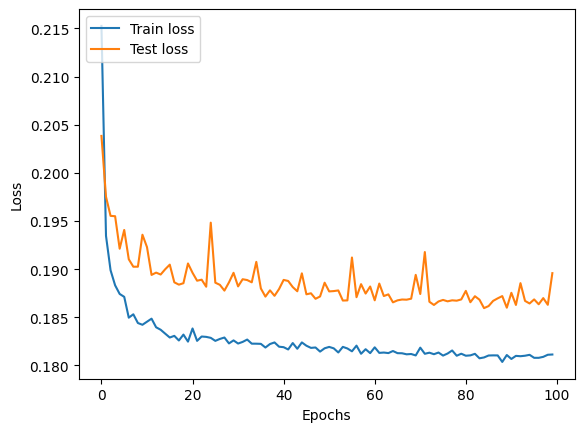

In [207]:
plt.plot(history.history['loss'] )
plt.plot(history.history['val_loss'] )
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(["Train loss","Test loss"],loc='upper left')
plt.show()

Accuracy graph

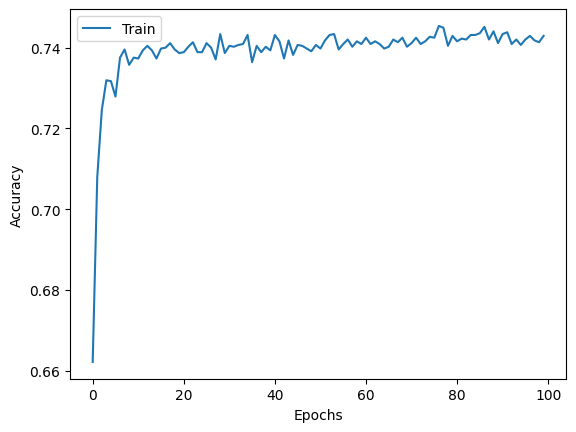

In [208]:
plt.plot(history.history['accuracy'] )
# plt.plot(history.history['val_binary_accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train',"Test"],loc='upper left')

plt.show()

Evaluate the model on train data

In [209]:
loss, accuracy = model.evaluate(x_train, y_train_array)

print(f"Train Loss: {loss}")
print(f"Train Accuracy: {accuracy}")

140/140 [==============================] - 0s 959us/step - loss: 0.1817 - accuracy: 0.7445
Train Loss: 0.1817273646593094
Train Accuracy: 0.7445042729377747


Evaluate the model on test data

In [210]:
loss, accuracy = model.evaluate(x_test, y_test_array)

print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

47/47 [==============================] - 0s 961us/step - loss: 0.1896 - accuracy: 0.7315
Test Loss: 0.18958479166030884
Test Accuracy: 0.7314939498901367


Making subarrays with zeros and ones

In [211]:
x_test_zeros = x_test[y_test == 0]
y_test_zeros = y_test_array[y_test == 0]

x_test_ones = x_test[y_test == 1]
y_test_ones = y_test_array[y_test == 1]

In [212]:
# Evaluate the model on the subset with zeros
loss_zeros, accuracy_zeros = model.evaluate(x_test_zeros, y_test_zeros)
print(f"Accuracy for test data with zeros: {accuracy_zeros}")

# Evaluate the model on the subset with ones
loss_ones, accuracy_ones = model.evaluate(x_test_ones, y_test_ones)
print(f"Accuracy for test data with ones: {accuracy_ones}")

24/24 [==============================] - 0s 1ms/step - loss: 0.2413 - accuracy: 0.6373
Accuracy for test data with zeros: 0.637333333492279
23/23 [==============================] - 0s 1ms/step - loss: 0.1369 - accuracy: 0.8274
Accuracy for test data with ones: 0.8274456262588501


Saving the model

In [213]:
model.save('my_model.h5')

c:\Users\misha\anaconda3\envs\cnv_predictor\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
